# Análise comparativa de algoritmos (The Traveling Salesman Problem - TSP)
**Estudante:** Pedro de Oliveira Guedes  
**Disciplina:** Algoritmos II  
**Instituição:** Universidade Federal de Minas Gerais (UFMG)  

## Introdução
O presente documento armazena os códigos escritos para realizar uma análise comparativa de algoritmos, evidenciando diferentes abordagens para solucionar o problema do caixeiro viajante, ou em inglês: Traveling Salesman Problem (TSP).

Ao decorrer deste documento, serão desenvolvidas as seguintes abordagens, que serão melhor discutidas nas respectivas seções:
1. Solução exata (Estratégia Branch and Bound)
2. Solução aproximada 1 (Algoritmo *Twice-Around-The-Tree*)
3. Solução aproximada 2 (Algoritmo de *Christofides*)

### Métodos de avaliação
A avaliação do resultado final produzido pelos algoritmos será realizada nos âmbitos de: Tempo; Espaço; e Qualidade da solução.

Para avaliar o tempo de execução, será empregada a biblioteca ```time```, que é nativa do Python. Serão utilizadas 5 casas decimais para garantir maior precisão da medição.

Para a avaliação do espaço, será calculado o espaço máximo cada uma das estruturas auxiliares criadas pelas funções ocupa. Ou seja, a própria construção da instância do problema não será levada em consideração.

A avaliação de qualidade será de acordo com o módulo da diferença entre a solução fornecida pelos algoritmos, e a solução ótima conhecida para aquele problema executado.

## Desenvolvimento
As células seguintes são destinadas ao desenvolvimento do trabalho.

### Importação de bibliotecas
Todas as bibliotecas necessárias para a execução do algoritmo serão importadas na célula a seguir.

In [ ]:
import os
import psutil

import threading
from time import sleep, time
import sys
try:
    import thread
except ImportError:
    import _thread as thread

import pandas as pd
import networkx as nx
import math

# import matplotlib.pyplot as plt

### Filtrando as instâncias
As instâncias do problema foram obtidas na internet e podem ser encontradas [neste site](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/), basta clicar em "```ALL_tsp.tar.gz```" para fazer o download de todos os arquivos. Após o download ser concluído, mova-o para uma pasta específica (no código abaixo, ela é nomeada "*tsp_instances*"), descompacte o arquivo e delete-o. Os novos itens que surgiram também devem ser compactados e ter seus arquivos comprimidos de origem deletados.

É necessário que o arquivo "```tp2_datasets.txt```" tenha sido baixado e esteja disponível para consulta, ele é responsável por nomear os datasets a serem utilizados pelo algoritmo. Satisfeitos os passos anteriores e a última condição, basta executar a célula abaixo e serão excluídos todos os arquivos que não pertencerem a lista de utilização.

In [ ]:
def delete_files_not_in_list(file_list_path, folder_path):
    with open(file_list_path, 'r') as file:
        valid_names = {line.split()[0] for line in file}
        valid_names.remove("Dataset")

    files_in_folder = os.listdir(folder_path)

    for file_name in files_in_folder:
        file_path = os.path.join(folder_path, file_name)
        if file_name.split('.')[0] not in valid_names and os.path.isfile(file_path):
            os.remove(file_path)
            print(f"Deleted: {file_name}")

    print(f"Quantidade de arquivos na lista: {len(valid_names)}")
    print(f"Quantidade de arquivos na pasta: {len(os.listdir(folder_path))}")

names_file_path = "./tp2_datasets.txt"

folder_path = "./tsp_instances/"

delete_files_not_in_list(names_file_path, folder_path)

### Definindo e testando *timeout*
Algumas instâncias do problema do caixeiro viajante podem ser muito longas para serem executadas pelos algoritmos desenvolvidos neste projeto. Dessa forma, deve haver uma forma de limitar o tempo utilizado pelas funções, evitando que o presente arquivo se torne impossível de executar por completo.

Essa limitação é feita através da criação de um [decorator](https://peps.python.org/pep-0318/), que recebe o *timeout* em segundos e o aplica sobre a função logo abaixo. Caso a execução da função leve mais tempo do que o *timeout* estabelecido, é lançada uma exceção.

In [ ]:
def quit_function(fn_name):
    print('{0} demorou demais'.format(fn_name), file=sys.stderr)
    sys.stderr.flush()
    thread.interrupt_main()

def exit_after(s):
    def outer(fn):
        def inner(*args, **kwargs):
            timer = threading.Timer(s, quit_function, args=[fn.__name__])
            timer.start()
            try:
                result = fn(*args, **kwargs)
            finally:
                timer.cancel()
            return result
        return inner
    return outer

# @exit_after(5)
# def countdown(n):
#     print('countdown started', flush=True)
#     for i in range(n, -1, -1):
#         print(i, end=', ', flush=True)
#         sleep(1)
#     print('countdown finished')

# try:
#     start = time()
#     countdown(10)
#     print(f"\nThe execution took {round(time() - start, 5)} seconds to finish")
# except:
#     print("The execution took too long to finish")

### Obtendo utilização de memória
É importante que os algoritmos também sejam analizados quanto a memória utilizada. Para isso, é utilizada a biblioteca `psutil`, que mede a memória gasta por um processo em diferentes momentos.

In [ ]:
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 ** 2 # Em MB

### Limpeza e criação das instâncias
Inicialmente, é necessário armazenar o nome das instâncias e informações úteis sobre ela, como a quantidade de nós e a solução ótima conhecida. Para isso, será utilizado um dicionário python.

In [ ]:
datasets_info = {}

with open("./tp2_datasets.txt", 'r') as file:
    for line in file:
        dataset_name, dataset_size, dataset_optimal_solution = line.split()

        datasets_info[dataset_name] = {
            "dataset_size": dataset_size,
            "dataset_optimal_solution": dataset_optimal_solution
        }

datasets_info = pd.DataFrame(datasets_info).drop(columns=["Dataset"])
datasets_info = datasets_info.transpose()
datasets_info

Note que muitos *datasets* possuem arrays como solução ótima. Ao realizar uma verificação manual no [site fornecido pelo professor para obter as soluções ótimas] (http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/STSP.html), foi constatado que em todos os casos a solução ótima era a maior do array. 

Dessa forma, será realizado um tratamento nos dados para que eles sejam uniformes e apresentem uma única solução ótima.

In [ ]:
correct_values = []

for value in datasets_info["dataset_optimal_solution"]:
    if '[' in value:
        new_value = value.replace('[', '').replace(']', '').split(',')
        new_value = [float(x) for x in new_value]
        new_value = max(new_value)
        correct_values.append(new_value)
    else:
        correct_values.append(float(value))

datasets_info['dataset_optimal_solution'] = correct_values

datasets_info

Após esse tratamento, é possível verificar que todas as instâncias do problema possuem apenas uma solução ótima.

#### Criação das instâncias
O processo de criação das instâncias consiste em acessar todos os arquivos de texto das instâncias, criar um novo nó com o identificador e coordenadas X e Y, e, após esse processo, para cada nó criado deve-se calcular a distância euclideana em que ele se encontra dos outros e adicionar essa aresta ao grafo.

Para iniciar o desenvolvimento, será criada uma classe ```Node``` com as informações obtidas sobre cada nó dos arquivos.

In [ ]:
class Node:
    def __init__(self, id: int, x: float, y: float):
        self.id = int(id)
        self.x = float(x)
        self.y = float(y)

    def __str__(self):
        return f"ID: {self.id}, X = {self.x}, Y = {self.y}\n"

    def get_dist(self, node) -> float:
        return math.sqrt((self.x - node.x)**2 + (self.y - node.y)**2)

Com a classe auxiliar dos nós criadas, é necessário que os nós das instâncias sejam listados para a construção do grafo e posterior solução do problema.

Para realizar essa tarefa, será criada uma função, que recebe o nome do arquivo no qual será realizada a construção do grafo e lista os nós presentes nele.

In [ ]:
def starts_with_number(line):
    try:
        int(line.split()[0])
        return True
    except:
        return False

def get_nodes(file_name: str) -> list:
    with open(f"./tsp_instances/{file_name}.tsp") as file:
        return [Node(*line.split()) for line in file if starts_with_number(line) and len(line.split()) == 3]

Após criar os nós que constituem a instância do caixeiro viajante no código, é necessário construir de fato os grafos que serão utilizados para solucionar o problema. Para isso, será utilizada a biblioteca ```NetworkX```.

Note que os grafos das instâncias do problema do caixeiro viajante são não-direcionados, ou seja, se já existe uma aresta *(u, v)*, não é necessário adicionar novamente a aresta *(v, u)*. Sendo assim, a construção do grafo de forma similar a uma **matriz de adjacência**, pode realizar o caminhamento pela diagonal principal, preenchendo somente a matriz triangular superior.

Essa abordagem não reduz a complexidade assintótica da construção do grafo, que continua sendo *O(n²)*, mas apresenta potencial para reduzir o tempo real necessário para finalizar a construção.

In [ ]:
@exit_after(60 * 30) # 30 minutos
def get_graph(nodes: list):
    graph = nx.Graph()
    
    for pos_node_1 in range(len(nodes)):
        for pos_node_2 in range(pos_node_1 + 1, len(nodes)):
            graph.add_edge(
                nodes[pos_node_1].id,
                nodes[pos_node_2].id,
                weight = nodes[pos_node_1].get_dist(nodes[pos_node_2])
            )

    return graph

### Algoritmo com Branch and Bound
A seguir, será implementado o algoritmo para solucionar o problema do caixeiro viajante, mas usando a estratégia Branch and Bound para obter a resposta exata em tempos menores.

A execução desse algoritmo depende da definição de estimativas de desempenho dos diferentes nós. Dessa forma, o primeiro passo para a construção do algoritmo é a definição de uma função para o cálculo das estimativas.

#### Cálculo da estimativa de distância
Para calcular a estimativa de distância que o caixeiro viajante percorreria no grafo, são coletadas as duas arestas de menor peso, para cada vértice do grafo. Elas são somadas e o resultado é dividido por 2, indicando a melhor estimativa para aquele momento.

Porém, o cálculo também deve levar em consideração o conjunto de vértices que já foram visitados e a ordem de visita. Isso é necessário, porque o elemento vértice que está na posição n está conectado pelo caminho do caixeiro viajante tanto ao vértice da posição n-1, quanto ao da posição n+1.

Dessa forma, as arestas que já foram utilizadas no caminhamento necessariamente devem ser somadas à estimativa, já que não é possível desfazer aquele caminho.

In [ ]:
def find_lightest_edge(edges, already_found):
    lightest_edge = float('inf')
    
    for edge in edges:
        curr_edge = edge[2]['weight']
        lightest_edge = curr_edge if curr_edge < lightest_edge and curr_edge != already_found else lightest_edge

    return lightest_edge

def calculate_upper_bound(graph, path_taken: list, nodes_included: set):
    upper_bound = 0

    for node in graph.nodes:
        node_index_in_path = None
        if node in nodes_included:
            node_index_in_path = path_taken.index(node)

        remaining_edges = 2
        # Há um nó antecessor ao atual no caminho construído, portanto, o peso da aresta entre os dois deve entrar na estimativa
        if node_index_in_path is not None and node_index_in_path - 1 >= 0:
            remaining_edges -= 1
            upper_bound += graph[path_taken[node_index_in_path - 1]][path_taken[node_index_in_path]]['weight']
            
        # Há um nó sucessor ao atual no caminho construído, portanto, o peso da aresta entre os dois deve entrar na estimativa
        if node_index_in_path is not None and node_index_in_path + 1 < len(path_taken):
            remaining_edges -= 1
            upper_bound += graph[path_taken[node_index_in_path + 1]][path_taken[node_index_in_path]]['weight']
            
        edges = graph.edges(node, data=True)
        # A quantidade de arestas mínimos restantes a serem adicionados é percorrida
        prev_edge_dist = -1
        for _ in range(remaining_edges):
            lightest_edge = find_lightest_edge(edges, prev_edge_dist)
            upper_bound += lightest_edge
            prev_edge_dist = lightest_edge

    return (upper_bound / 2) # A soma das arestas é feita duas vezes, uma para cada nó

#### Nó de possibilidade
Para verificar as possibilidades e filtrá-las quanto a estimativa, é necessário que os nós armazenem certos valores ao serem inseridos na Fila de Prioridade. Dessa forma, será criada a classe ```Possibility Node``` contendo:
1. **Nível:** O nível da árvore de possibilidades em que aquele nó se encontra;
2. **Custo:** O custo de caminhamento entre nós do grafo escolhidos até então;
3. **Solução Parcial:** O conjunto de nós do grafo que foi escolhido até aquela iteração.

In [ ]:
class PossibilityNode:
    def __init__(self, level: int, cost: float, partial_solution: list, nodes_included: set, graph):
        self.level = level
        self.cost = cost
        self.partial_solution = partial_solution
        self.nodes_included = nodes_included
        self.up_bound = calculate_upper_bound(graph, partial_solution, nodes_included)

    def __lt__(self, other):
        return True if self.up_bound < other.up_bound else self.level > other.level

#### Implementação Branch and Bound
Aqui o algoritmo será implementado

In [ ]:
@exit_after(60 * 30) # 30 minutos
def traveling_salesman_bnb(graph, graph_size: int) -> float:
    root = PossibilityNode(level=0, cost=0, partial_solution=[1], nodes_included={1}, graph=graph)
    p_queue = nx.utils.mapped_queue.MappedQueue()
    p_queue.push(root, root.up_bound)
    best_distance_yet = float('inf')

    while len(p_queue.heap) > 0:
        node = p_queue.pop().element

        if node.level > graph_size:
            best_distance_yet = node.cost
            
        elif node.up_bound < best_distance_yet:
            if node.level < graph_size:
                for available_node in graph.nodes:
                    if available_node not in node.nodes_included:
                        new_cost = graph[node.partial_solution[-1]][available_node]['weight']
                        extended_solution = node.partial_solution + [available_node]
                        extended_nodes = node.nodes_included.copy()
                        extended_nodes.add(available_node)
                        
                        new_node = PossibilityNode(
                            level = node.level + 1,
                            cost = node.cost + new_cost,
                            partial_solution = extended_solution,
                            nodes_included = extended_nodes,
                            graph = graph
                        )
                        if new_node.up_bound < best_distance_yet:
                            p_queue.push(new_node, new_node.up_bound)
                            
            else:
                new_cost = graph[node.partial_solution[-1]][1]['weight']
                extended_solution, extended_nodes = node.extend_partial_solution(1)
                final_node = PossibilityNode(
                    level = node.level + 1,
                    cost = node.cost + new_cost,
                    partial_solution = extended_solution,
                    nodes_included = extended_nodes,
                    graph = graph
                )
                if final_node.up_bound < best_distance_yet:
                    p_queue.push(final_node , final_node.up_bound)

    return best_distance_yet

### Algoritmo aproximativo (Twice Around The Tree)
Nessa implementação são assumidas algumas restrições, como:
- **c(u, v) >= 0:** O custo das arestas é sempre maior ou igual a 0;
- **c(u, v) = 0 sse u = v:** O custo de uma aresta somente será igual a 0 caso ela ligue um vértice a si mesmo;
- **c(u, v) = c(v, u):** O custo para navegar entre dois vértices independe do ponto de origem;
- **c(u, v) <= c(u, w) + c(w, v):** Os grafos seguem o *princípio de desigualdade triângular*, onde a utilização de um vértice intermediário para uma aresta não pode resultar em um custo inferior ao da aresta que não usa um vértice intermediário.

Será utilizada a biblioteca ```networkx``` para encontrar a árvore geradora mínima e realizar o caminhamento pré-ordem, que são etapas necessárias para a execução do algoritmo.

In [ ]:
@exit_after(60 * 30) # 30 minutos
def approximative_tsp_twice_around_the_tree(graph) -> float:
    mst = nx.minimum_spanning_tree(graph)

    hamiltonian_cycle = list(nx.dfs_preorder_nodes(mst))

    hamiltonian_cycle.append(hamiltonian_cycle[0])

    return sum([graph[hamiltonian_cycle[i]][hamiltonian_cycle[i + 1]]['weight'] for i in range(len(hamiltonian_cycle) - 1)])

### Algoritmo aproximativo (Christofides)
O algoritmo de Christofides, assim como o *Twice Around The Tree*, computa a árvore geradora mínima do grafo para utilizar como estimativa de distância a ser percorrida.

Sendo assim, além da utilização da biblioteca ```networkx``` para encontrar a árvore geradora mínima e realizar o caminhamento pré-ordem, ela também será utilizada para encontrar o *Matching* máximo de menor peso entre arestas do grafo.

In [ ]:
@exit_after(60 * 30) # 30 minutos
def approximative_tsp_christofides(graph) -> float:
    mst = nx.minimum_spanning_tree(graph)

    odd_degree_nodes = [node for node in mst.nodes if mst.degree(node) % 2 == 1]

    subgraph = graph.subgraph(odd_degree_nodes)

    min_weight_matching = nx.algorithms.min_weight_matching(subgraph)

    for node_1, node_2 in min_weight_matching:
        mst.add_edge(node_1, node_2, weight=graph[node_1][node_2]['weight'])

    hamiltonian_cycle = list(nx.dfs_preorder_nodes(mst))

    hamiltonian_cycle.append(hamiltonian_cycle[0])

    return sum([graph[hamiltonian_cycle[i]][hamiltonian_cycle[i + 1]]['weight'] for i in range(len(hamiltonian_cycle) - 1)])

# Testes
Para realizar o teste dos algoritmos, serão utilizadas todos os *datasets* disponíveis, em ordem crescente de tamanho. Além disso, a execução dos algoritmos para as instâncias não devem ultrapassar 30 minutos, tendo a execução abortada caso contrário.

A execução dos algoritmos em ordem crescente no tamanho dos datasets é proposital, pois é possível admitir que, se um algoritmo levou mais de 30 minutos para executar sobre uma instância de tamanho X, ele certamente levará um tempo tão grande quanto para uma instância de tamanho X + 1. 

Dessa forma, para economizar recursos computacionais, se a execução de uma instância com X pontos for abortada antes do fim, tanto essa instância quanto as que possuírem tamanho igual ou superior também serão abortadas, marcando um valor nulo na tabela de resultados.

## Testando o algoritmo exato com *Branch and Bound*
O primeiro algoritmo testado será o de Branch and Bound, iterando por todas as instâncias e mensurando o tempo necessário para execução e o espaço ocupado pela instância em memória.

In [ ]:
def test_bnb():
    datasets_info["dataset_bnb_solution"] = [None] * len(datasets_info)
    datasets_info["dataset_bnb_time"] = [None] * len(datasets_info)
    datasets_info["dataset_bnb_memory"] = [None] * len(datasets_info)

    for dataset_name in datasets_info.index:
        try:
            nodes = get_nodes(dataset_name)
            graph = get_graph(nodes)
            
            start_time = time()
            start_memory = get_memory_usage()

            solution = traveling_salesman_bnb(graph, len(graph.nodes))
            
            end_memory = get_memory_usage()
            end_time = time()
            
            datasets_info.loc[dataset_name, "dataset_bnb_solution"] = round(solution, 2)
            datasets_info.loc[dataset_name, "dataset_bnb_time"] = round(end_time - start_time, 7)
            datasets_info.loc[dataset_name, "dataset_bnb_memory"] = round(end_memory - start_memory, 3)

            datasets_info.to_csv("./datasets_info_bnb.csv")
        except Exception as e:
            print(e)
            break
        except KeyboardInterrupt:
            print(f"A instância \"{dataset_name}\" levou mais de 30 minutos para executar em BNB")
            break

test_bnb()

## Testando o algoritmo aproximativo com *Twice around the Tree*
Esse algoritmo será testado de forma similar ao anterior.

In [ ]:
def test_twice_around_the_tree():
    datasets_info["dataset_approx_twice_around_the_tree_solution"] = [None] * len(datasets_info)
    datasets_info["dataset_approx_twice_around_the_tree_time"] = [None] * len(datasets_info)
    datasets_info["dataset_approx_twice_around_the_tree_memory"] = [None] * len(datasets_info)

    for dataset_name in datasets_info.index:
        try:
            nodes = get_nodes(dataset_name)
            graph = get_graph(nodes)
            
            start = time()
            start_memory = get_memory_usage()

            solution = approximative_tsp_twice_around_the_tree(graph)

            end_memory = get_memory_usage()
            end = time()
            
            datasets_info.loc[dataset_name, "dataset_approx_twice_around_the_tree_solution"] = round(solution, 2)
            datasets_info.loc[dataset_name, "dataset_approx_twice_around_the_tree_time"] = round(end - start, 7)
            datasets_info.loc[dataset_name, "dataset_approx_twice_around_the_tree_memory"] = round(end_memory - start_memory, 3)

            datasets_info.to_csv("./datasets_info_tatt.csv")
        except Exception as e:
            print(e)
            break
        except KeyboardInterrupt:
            print(f"A instância \"{dataset_name}\" levou mais de 30 minutos para executar em Twice Around The Tree")
            break

test_twice_around_the_tree()

A instância `rl11849`, que possui 11.849 pontos, passou a consumir mais de 16Gb de memória da máquina. Buscando evitar danificar o equipamento de teste, a execução do algoritmo foi terminada a força.

## Testando o algoritmo aproximativo de *Christofides*
Esse algoritmo será testado de forma similar ao anterior.

Porém, como a execução da instância `rl11849` ocupou muita memória RAM, o computador precisou ser reiniciado para continuar os experimentos. Dessa forma, os resultados dessa iteração de teste serão salvos em um novo arquivo `csv`, para não sobrescrever os dados de teste anteriormente obtidos.

In [ ]:
def test_christofides():
    datasets_info["dataset_approx_christofides_solution"] = [None] * len(datasets_info)
    datasets_info["dataset_approx_christofides_time"] = [None] * len(datasets_info)
    datasets_info["dataset_approx_christofides_memory"] = [None] * len(datasets_info)

    for dataset_name in datasets_info.index:
        try:
            nodes = get_nodes(dataset_name)
            graph = get_graph(nodes)
            
            start = time()
            start_memory = get_memory_usage()

            solution = approximative_tsp_christofides(graph)

            end_memory = get_memory_usage()
            end = time()
            
            datasets_info.loc[dataset_name, "dataset_approx_christofides_solution"] = round(solution, 2)
            datasets_info.loc[dataset_name, "dataset_approx_christofides_time"] = round(end - start, 7)
            datasets_info.loc[dataset_name, "dataset_approx_christofides_memory"] = round(end_memory - start_memory, 3)

            datasets_info.to_csv("./datasets_info_christofides.csv")
        except Exception as e:
            print(e.with_traceback())
            break
        except KeyboardInterrupt:
            print(f"A instância \"{dataset_name}\" levou mais de 30 minutos para executar em Christofides")
            break

test_christofides()

# Compilando os resultados
Após realizar as baterias de testes para cada um dos três algoritmos, foram gerados três arquivos `csv` diferentes com os resultados obtidos em cada um. É necessário juntá-los e, a partir deles, gerar gráficos e tabelas que auxiliem a comparação entre os algoritmos.

In [ ]:
csv_files = ["datasets_info_bnb.csv", "datasets_info_tatt.csv", "datasets_info_christofides.csv"]

dfs = [pd.read_csv(file) for file in csv_files]

joined_df = pd.concat(dfs, axis=1)
joined_df = joined_df.loc[:, ~joined_df.columns.duplicated()]

joined_df = joined_df.rename(columns={"Unnamed: 0": "dataset_name"})
joined_df = joined_df.set_index("dataset_name")

joined_df = joined_df.fillna("NA")

joined_df.to_csv("./compiled_datasets_results.csv")
joined_df

In [96]:
# df = pd.read_csv('compiled_datasets_results.csv')

# bnb_time_sum = df['dataset_bnb_time'].sum()
# bnb_time_avg = df['dataset_bnb_time'].mean()
# print(f"Total time taken for Branch and Bound: {bnb_time_sum} seconds")
# print(f"Average time taken for Branch and Bound: {bnb_time_avg} seconds")

# print("\n ============================= \n")

# tatt_time_sum = df['dataset_approx_twice_around_the_tree_time'].sum()
# tatt_time_avg = df['dataset_approx_twice_around_the_tree_time'].mean()
# print(f"Total time taken for Twice Around The Tree: {tatt_time_sum} seconds")
# print(f"Average time taken for Twice Around The Tree: {tatt_time_avg} seconds")

# print("\n ============================= \n")

# christofides_time_sum = df['dataset_approx_christofides_time'].sum()
# christofides_time_avg = df['dataset_approx_christofides_time'].mean()
# print(f"Total time taken for Christofides: {christofides_time_sum} seconds")
# print(f"Average time taken for Christofides: {christofides_time_avg} seconds")

Total time taken for Branch and Bound: 0.0 seconds
Average time taken for Branch and Bound: nan seconds


Total time taken for Twice Around The Tree: 294.5347221 seconds
Average time taken for Twice Around The Tree: 4.034722220547946 seconds


Total time taken for Christofides: 3992.0 seconds
Average time taken for Christofides: 57.02857142857143 seconds


In [95]:
# df = pd.read_csv('compiled_datasets_results.csv')

# bnb_memory_sum = abs(df['dataset_bnb_memory'].sum())
# bnb_memory_avg = abs(df['dataset_bnb_memory'].mean())
# print(f"Total memory used for Branch and Bound: {bnb_memory_sum} MB")
# print(f"Average memory used for Branch and Bound: {bnb_memory_avg} MB")

# print("\n ============================= \n")

# tatt_memory_sum = abs(df['dataset_approx_twice_around_the_tree_memory'].sum())
# tatt_memory_avg = abs(df['dataset_approx_twice_around_the_tree_memory'].mean())
# print(f"Total memory used for Twice Around The Tree: {tatt_memory_sum} MB")
# print(f"Average memory used for Twice Around The Tree: {tatt_memory_avg} MB")

# print("\n ============================= \n")

# christofides_memory_sum = abs(df['dataset_approx_christofides_memory'].sum())
# christofides_memory_avg = abs(df['dataset_approx_christofides_memory'].mean())
# print(f"Total memory used for Christofides: {christofides_memory_sum} MB")
# print(f"Average memory used for Christofides: {christofides_memory_avg} MB")

Total memory used for Branch and Bound: 0.0 MB
Average memory used for Branch and Bound: nan MB


Total memory used for Twice Around The Tree: 16805.926 MB
Average memory used for Twice Around The Tree: 230.21816438356163 MB


Total memory used for Christofides: 8373.151 MB
Average memory used for Christofides: 119.61644285714286 MB


## Gerando gráficos
Os gráficos serão gerados utilizando a biblioteca `Matplotlib`.

### Twice Around The Tree

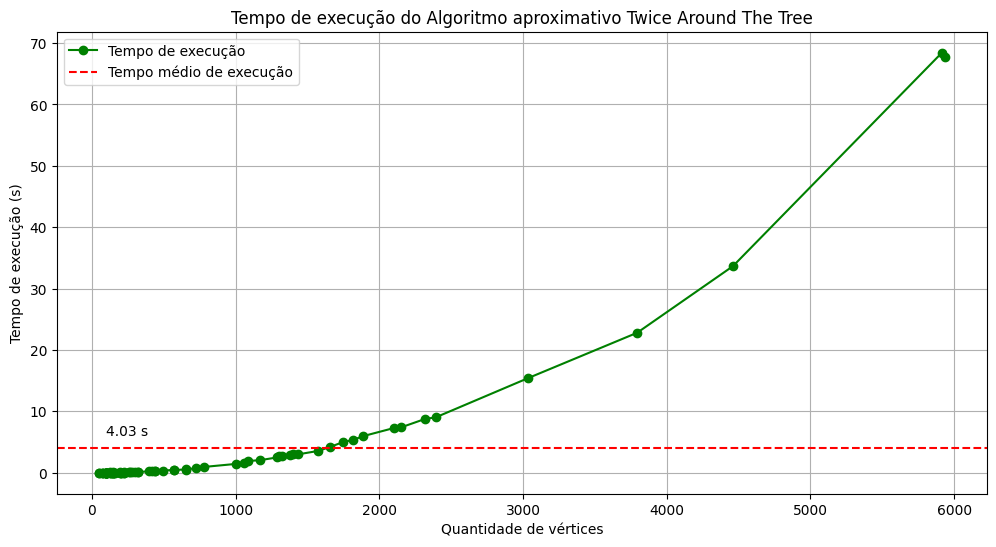

In [98]:
# df = pd.read_csv('datasets_info_tatt.csv')

# fig, ax = plt.subplots(figsize=(12, 6))
# df.plot(x='dataset_size', y='dataset_approx_twice_around_the_tree_time', kind='line', marker='o', ax=ax, color='green')

# ax.axhline(y=tatt_time_avg, color='red', linestyle='--', label='Average Time')

# plt.title('Tempo de execução do Algoritmo aproximativo Twice Around The Tree')
# plt.xlabel('Quantidade de vértices')
# plt.ylabel('Tempo de execução (s)')

# ax.annotate(f'{round(tatt_time_avg, 2)} s', xy=(0, tatt_time_avg), xytext=(100, tatt_time_avg + 2))

# ax.legend(['Tempo de execução', 'Tempo médio de execução'])

# plt.grid(True)

# plt.savefig("./charts/twice_around_the_tree_time.png")

# plt.show()

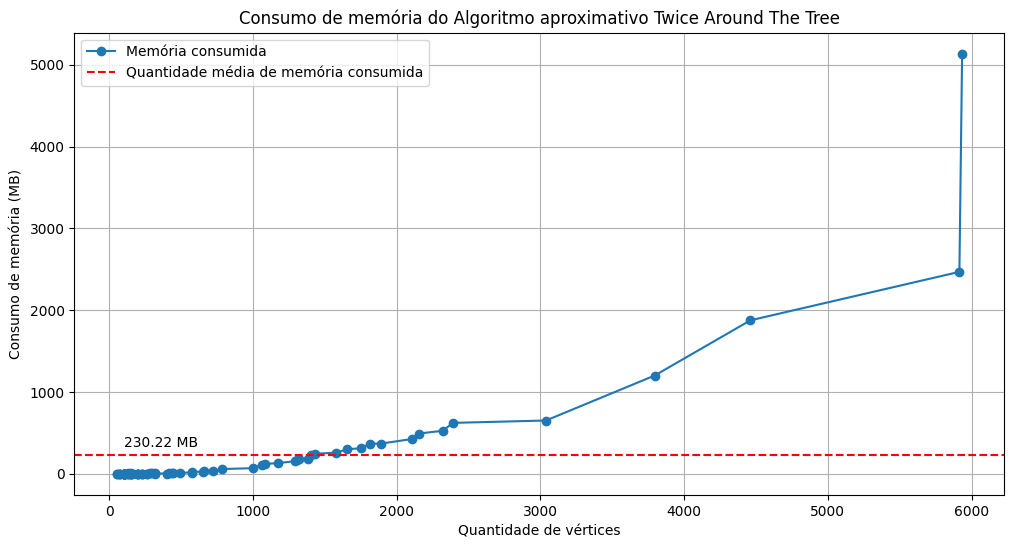

In [97]:
# df = pd.read_csv('datasets_info_tatt.csv')

# df['dataset_approx_twice_around_the_tree_memory'] = df['dataset_approx_twice_around_the_tree_memory'].abs()

# fig, ax = plt.subplots(figsize=(12, 6))
# df.plot(x='dataset_size', y='dataset_approx_twice_around_the_tree_memory', kind='line', marker='o', ax=ax)

# ax.axhline(y=tatt_memory_avg, color='red', linestyle='--', label='Average Memory')

# plt.title('Consumo de memória do Algoritmo aproximativo Twice Around The Tree')
# plt.xlabel('Quantidade de vértices')
# plt.ylabel('Consumo de memória (MB)')

# ax.annotate(f'{round(tatt_memory_avg, 2)} MB', xy=(0, tatt_memory_avg), xytext=(100, tatt_memory_avg + 100))

# ax.legend(['Memória consumida', 'Quantidade média de memória consumida'])

# plt.grid(True)

# plt.savefig("./charts/twice_around_the_tree_memory.png")

# plt.show()

### Christofides

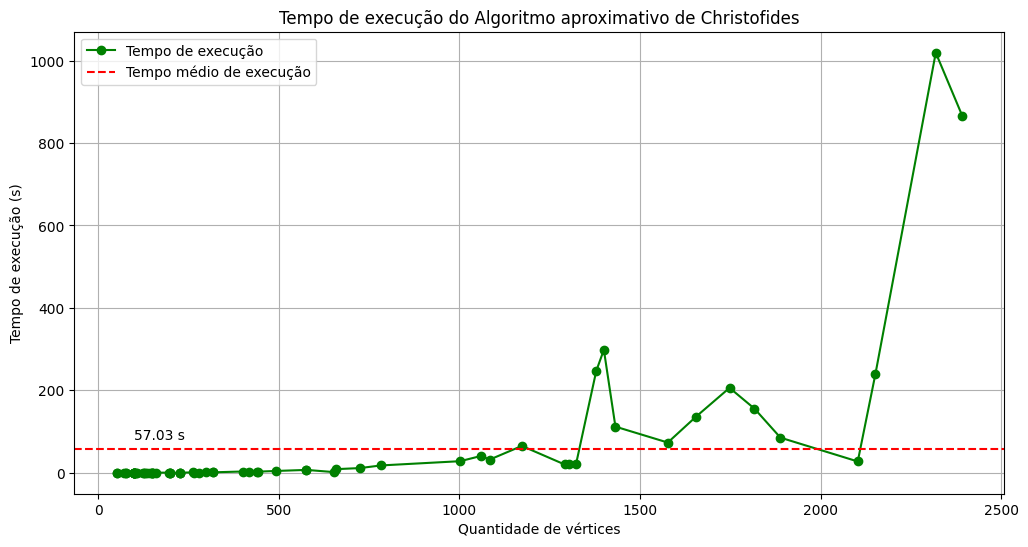

In [94]:
# df = pd.read_csv('datasets_info_christofides.csv')

# fig, ax = plt.subplots(figsize=(12, 6))
# df.plot(x='dataset_size', y='dataset_approx_christofides_time', kind='line', marker='o', ax=ax, color='green')

# ax.axhline(y=christofides_time_avg, color='red', linestyle='--', label='Average Time')

# plt.title('Tempo de execução do Algoritmo aproximativo de Christofides')
# plt.xlabel('Quantidade de vértices')
# plt.ylabel('Tempo de execução (s)')

# ax.annotate(f'{round(christofides_time_avg, 2)} s', xy=(0, christofides_time_avg), xytext=(100, christofides_time_avg + 25))

# ax.legend(['Tempo de execução', 'Tempo médio de execução'])

# plt.grid(True)

# plt.savefig("./charts/christofides_time.png")

# plt.show()

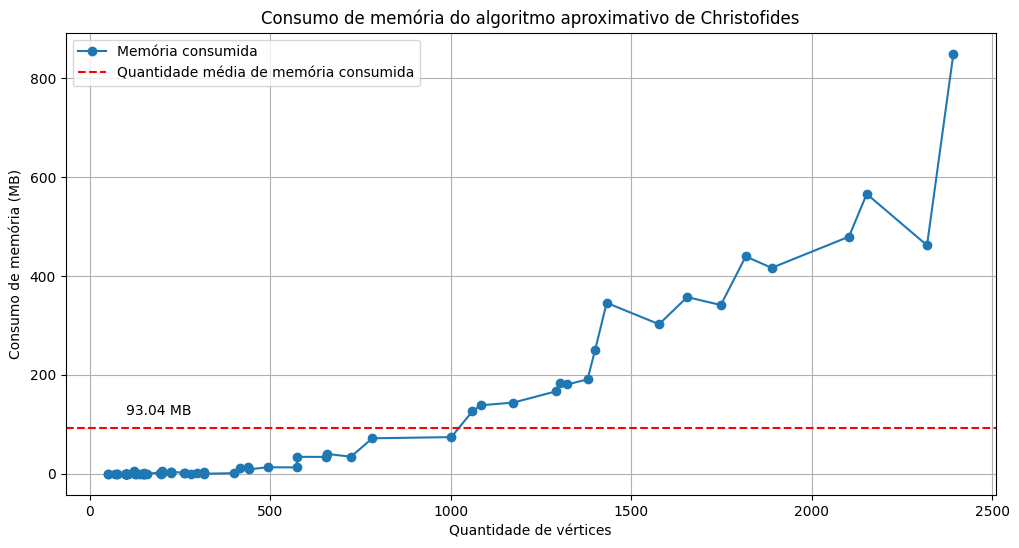

In [93]:
# df = pd.read_csv('datasets_info_christofides.csv')

# df['dataset_approx_christofides_memory'] = df['dataset_approx_christofides_memory'].abs()

# fig, ax = plt.subplots(figsize=(12, 6))
# df.plot(x='dataset_size', y='dataset_approx_christofides_memory', kind='line', marker='o', ax=ax)

# ax.axhline(y=christofides_memory_avg, color='red', linestyle='--', label='Average Memory')

# plt.title('Consumo de memória do algoritmo aproximativo de Christofides')
# plt.xlabel('Quantidade de vértices')
# plt.ylabel('Consumo de memória (MB)')

# ax.annotate(f'{round(christofides_memory_avg, 2)} MB', xy=(0, christofides_memory_avg), xytext=(100, christofides_memory_avg + 25))

# ax.legend(['Memória consumida', 'Quantidade média de memória consumida'])

# plt.grid(True)

# plt.savefig("./charts/christofides_memory.png")

# plt.show()

### Final

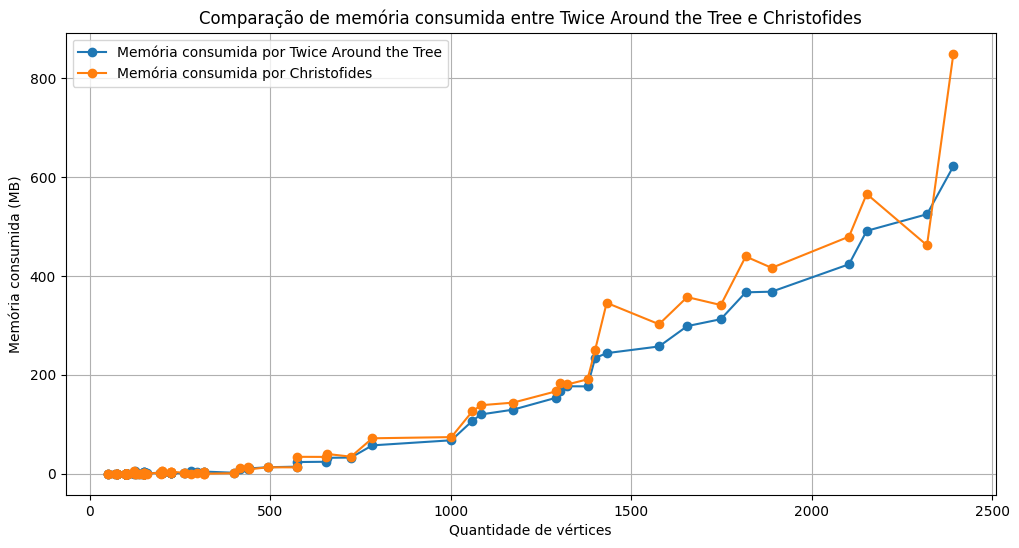

In [92]:
# df_tatt = pd.read_csv('datasets_info_tatt.csv')
# df_tatt.dropna(inplace=True)

# df_christofides = pd.read_csv('datasets_info_christofides.csv')
# df_christofides.dropna(inplace=True)

# df_tatt['dataset_approx_twice_around_the_tree_memory'] = df_tatt['dataset_approx_twice_around_the_tree_memory'].abs()
# df_christofides['dataset_approx_christofides_memory'] = df_christofides['dataset_approx_christofides_memory'].abs()

# merged_df = pd.merge(df_tatt, df_christofides, on='dataset_size')

# fig, ax = plt.subplots(figsize=(12, 6))

# merged_df.plot(x='dataset_size', y=['dataset_approx_twice_around_the_tree_memory', 'dataset_approx_christofides_memory'], kind='line', marker='o', ax=ax)

# plt.title('Comparação de memória consumida entre Twice Around the Tree e Christofides')
# plt.xlabel('Quantidade de vértices')
# plt.ylabel('Memória consumida (MB)')

# ax.legend(['Memória consumida por Twice Around the Tree', 'Memória consumida por Christofides'])

# plt.grid(True)

# plt.savefig('./charts/memory_consumption_comparison.png')

# plt.show()


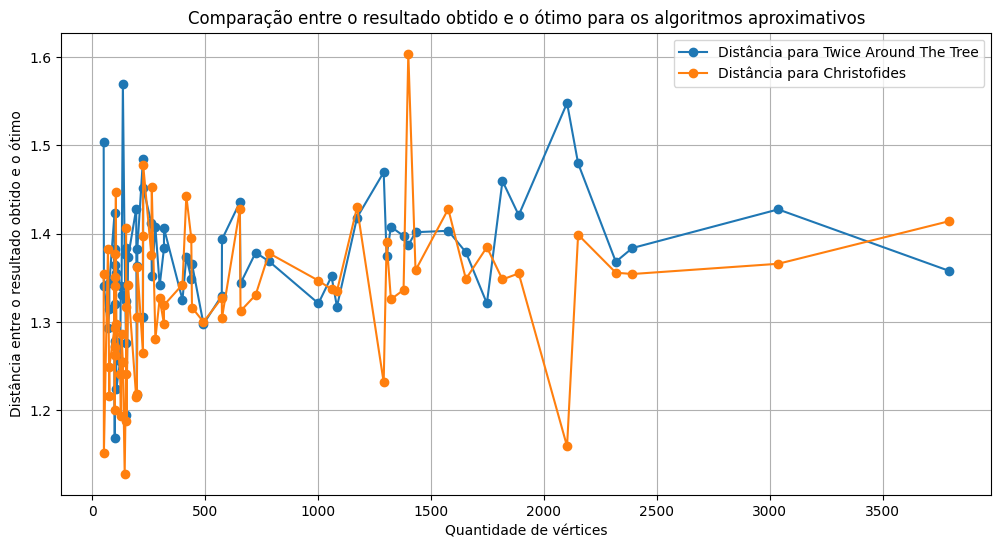

In [91]:
# df = pd.read_csv('compiled_datasets_results.csv')

# df = df.dropna(subset=['dataset_approx_christofides_solution'])

# df['delta_twice_around_the_tree'] = df['dataset_approx_twice_around_the_tree_solution'] / df['dataset_optimal_solution']
# df['delta_christofides'] = df['dataset_approx_christofides_solution'] / df['dataset_optimal_solution']

# fig, ax = plt.subplots(figsize=(12, 6))
# df.plot(x='dataset_size', y=['delta_twice_around_the_tree', 'delta_christofides'], kind='line', marker='o', ax=ax)

# plt.title('Comparação entre o resultado obtido e o ótimo para os algoritmos aproximativos')
# plt.xlabel('Quantidade de vértices')
# plt.ylabel('Distância entre o resultado obtido e o ótimo')

# ax.legend(['Distância para Twice Around The Tree', 'Distância para Christofides'])

# plt.grid(True)

# plt.savefig('./charts/delta_values_comparison.png')

# plt.show()


In [90]:
# df = pd.read_csv('compiled_datasets_results.csv')

# df = df.dropna(subset=['dataset_approx_christofides_solution'])

# df['delta_twice_around_the_tree'] = df['dataset_approx_twice_around_the_tree_solution'] / df['dataset_optimal_solution']
# df['delta_christofides'] = df['dataset_approx_christofides_solution'] / df['dataset_optimal_solution']

# max_distance = df['delta_twice_around_the_tree'].max()
# print(f"Maximum distance to optimal solution (Twice Around The Tree): {max_distance}")

# min_distance = df['delta_twice_around_the_tree'].min()
# print(f"Minimum distance to optimal solution (Twice Around The Tree): {min_distance}")

# avg_distance = df['delta_twice_around_the_tree'].mean()
# print(f"Average distance to optimal solution (Twice Around The Tree): {avg_distance}")

# print("\n ============================= \n")

# max_distance = df['delta_christofides'].max()
# print(f"Maximum distance to optimal solution (Christofides): {max_distance}")

# min_distance = df['delta_christofides'].min()
# print(f"Minimum distance to optimal solution (Christofides): {min_distance}")

# avg_distance = df['delta_christofides'].mean()
# print(f"Average distance to optimal solution (Christofides): {avg_distance}")

Maximum distance to optimal solution (Twice Around The Tree): 1.569810895713636
Minimum distance to optimal solution (Twice Around The Tree): 1.1689264260873493
Average distance to optimal solution (Twice Around The Tree): 1.366583148477161


Maximum distance to optimal solution (Christofides): 1.6038470710985244
Minimum distance to optimal solution (Christofides): 1.1283492491928182
Average distance to optimal solution (Christofides): 1.3263916668573266
